In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing
import scipy.stats as st

from functions import *

# SARIMA
# diagramme de corrélation simple :
from statsmodels.tsa.stattools import acf, pacf

# modèle SARIMA :
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

import itertools
from IPython.display import clear_output
from time import time

Enercoop est une société coopérative spécialisée dans les éneriges renouvelables.

Pour gérer au mieux la production future, nous allons prédire la consommation électrique jusqu'en avril 2019

## Préparation des données

### Consommation d'éléctricité mensuelles

[Source](https://www.rte-france.com/fr/eco2mix/eco2mix-telechargement) : RTE est la société public gérant le réseau de transport d'électricité de france

On a :
- pour 01/01/2010 au 01/11/18
- données régionale et nationale
- pour différents types de production et consommation
- les échanges internationaux

on ne va garder que la comonsomation nationale à ces dates


In [2]:
# ouverture avec parsing de la date
f = lambda string: np.nan if string == '0000-00' else datetime.strptime(string, '%Y-%m')
conso = pd.read_table("datas/eCO2mix_RTE_energie_M.xls", parse_dates=[0], date_parser=f)
# on enleve le caracètre non-reconnu
conso = conso.replace('�', 'é', regex=True); conso.columns = conso.columns.str.replace('�', 'é')

Utilisation de la fonction strptime pour parser la date en objet datetime

In [3]:
# on ne garde que la date et la valeur de la consommation en france
conso = conso.loc[conso['Territoire'] == 'France', ['Mois', 'Consommation totale']]
conso.columns = ['date', 'consommation']

# on supprime les dates nulles
conso = conso.dropna(subset=['date'])

Text(0.5,1,'Consommation électrique en France (MW)')

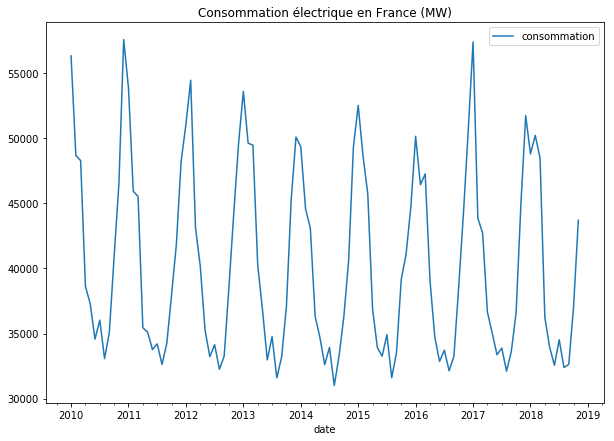

In [4]:
conso.plot(x='date', figsize=(10,7))
plt.title('Consommation électrique en France (MW)')

On constate :
- une **tendance stable**
- une **saisonnalité sur 1 an**

### Effet température (DJU)

Le DJ est la différence (seulement positive) entre la température moyenne de la journée et la température de référence, fixée à 21°. 

Le DJU (degrés jour) est la somme des DJ quotidiens pour chaque mois.

[Source](https://cegibat.grdf.fr/simulateur/calcul-dju) : GRDF : le principal distributeur de gaz en france et en europe

DJU mensuel à Roissy entre le 01/01/2010 et le 01/05/2018.



In [5]:
# ouverture du fichier
dju = pd.read_table('datas/dju_roissy.txt')

on va mettre les mois en colonne, joint a l'année, et convertir la date en datetime

In [6]:
# on supprime la colonne TOTAL
dju = dju.drop('TOTAL', axis=1)
# on renomme les colonnes
dju.columns = ['annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# on fait l'inverse d'un pivot table : on met les mois dans une seul colonne
dju = pd.melt(dju, id_vars='annee', var_name='mois', value_name='dju')

In [7]:
# on concatène les annees et les mois, et on convertie en datetime
dju['date'] = pd.to_datetime(dju['annee'].astype(str) + '-' + dju['mois'], format='%Y-%m')
dju = dju.drop(['annee', 'mois'], axis=1)

In [8]:
# on supprime les dju = 0 (ce sont des données nulles)
dju = dju.loc[dju['dju'] != 0]

In [9]:
dju.head(7)

,dju,date
0,624.8,2010-01-01
1,507.2,2011-01-01
2,454.5,2012-01-01
3,548.2,2013-01-01
4,434.4,2014-01-01
5,507.0,2015-01-01
6,477.6,2016-01-01


Text(0.5,1,'DJU à Roissy')

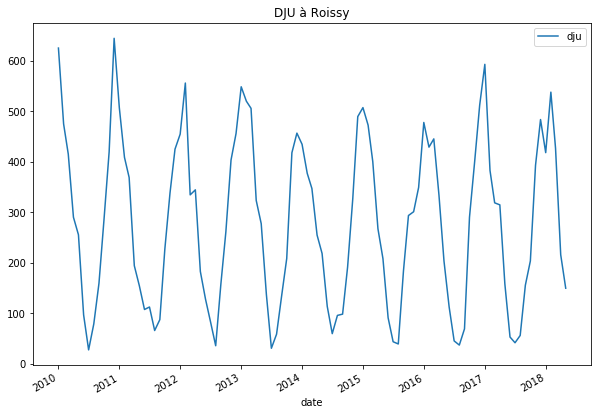

In [10]:
dju.plot(x='date', figsize=(10,7))
plt.title('DJU à Roissy')

On observe une tendance similaire à la consommation d'énergie.

La consommation électrique semble bien dépendante de la température.

### Jointure

On effectue une jointuer sur la date. On fait une jointure interne pour ne garder que les dates qui ont les deux mesures.

In [11]:
data = pd.merge(dju, conso, how='inner')

# on met la date en index
data = data.set_index('date').sort_index()

Nous avons donct des données du 01/01/2010 au 01/05/2018

In [12]:
data.head(8)

,dju,consommation
date,,
2010-01-01,624.8,56342
2010-02-01,474.7,48698
2010-03-01,414.9,48294
2010-04-01,290.1,38637
2010-05-01,255.4,37284
2010-06-01,96.9,34567
2010-07-01,27.7,36031
2010-08-01,79.0,33069


## Missions

### Mission 1

<div class="panel panel-success">
    <div class="panel-heading"> 
        Ennoncé
    </div>
    <div class="panel-body"> 
        Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
    </div>
</div>


Comme la consommation électrique semble en partie expliquée par la température, nous pouvons la corriger.
Nous aurons ainsi la consommation qui n'est pas liée à l'effet température (comme le chauffage ou l'éclairage).

Nous allons quantifier la part de consommation expliquée par la température avec une régression linéaire, car la relation semble fortement corrélée linéairement :

Text(0,0.5,'Consommation(MW)')

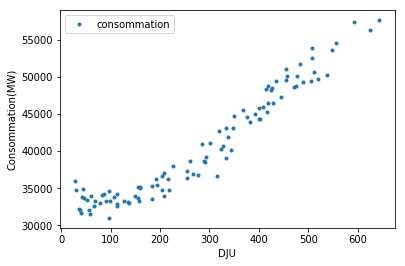

In [13]:
data.plot(x='dju', y='consommation', style='.')
plt.xlabel('DJU')
plt.ylabel('Consommation(MW)')

#### Modèle de régression linéaire simple

In [14]:
import statsmodels.api as sm

In [15]:
X = sm.add_constant(data['dju'])
y = data['consommation']
reg_result = sm.OLS(y, X).fit()

Text(0,0.5,'consommation')

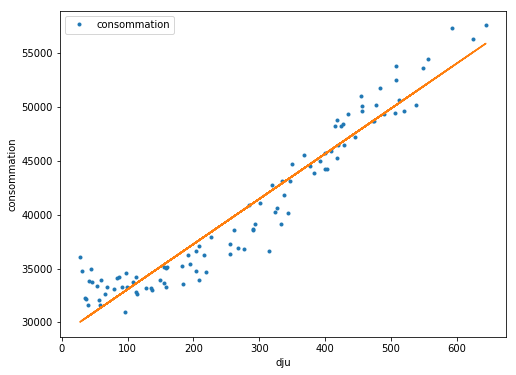

In [16]:
data.plot(x='dju', y='consommation', style='.', figsize=(8,6))
plt.plot(data['dju'], reg_result.predict(sm.add_constant(data['dju'])))
plt.xlabel('dju'); plt.ylabel('consommation')

##### Significativité du modèle

In [17]:
reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consommation   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1154.
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           2.31e-56
Time:                        20:09:48   Log-Likelihood:                -913.31
No. Observations:                 101   AIC:                             1831.
Df Residuals:                      99   BIC:                             1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.887e+04    401.939     71.822      0.000    2.81e+04    2.97e+04
dju           42.0063      1.237     33.965      0.000      39.552      44.460
==============================================================================
Omnibus:                        0.504   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.336
Skew:                           0.141   Prob(JB):                        0.845
Kurtosis:                       3.017   Cond. No.                         635.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Significativité du modèle
- F-valeur est proche de 0
- les t-tests effectuées sur les coefficients renvoient une p-valeur de 0

Le DJU est significatif pour expliquer la consommation électrique

##### Analyse des résidus

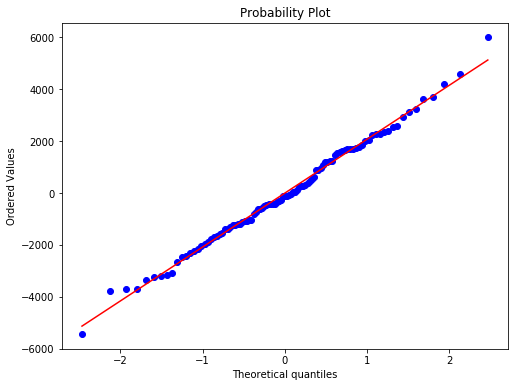

In [18]:
# on affiche le Q-Q plot
fig, ax = plt.subplots(figsize=(8,6))
_ = st.probplot(reg_result.resid, plot=ax, fit=True)

Selon le QQ-plot, les résidus semblent gaussiens.

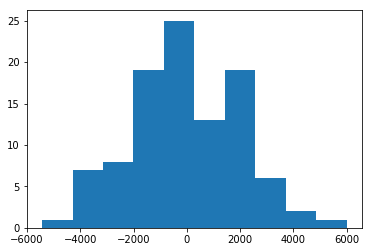

In [19]:
res = plt.hist(reg_result.resid)

In [20]:
stats.shapiro(reg_result.resid)[1]

0.9739853739738464

##### Variation expliquée

Le coefficient de détermination $R^2 = 0.92$, la température (DJU) explique donc la majeur partie de la consommation électrique.

Selon notre modèle, seulement 8% de la consommation électrique est utilisée pour autre chose que ce qui est liée à la température (chauffage & éclairage ?)

#### Correction de la consommation électrique en fonction de l'effet température

On va retrancher l'effet température à la consommation électrique

In [21]:
data['consommation_corrigee'] = data['consommation'] - data['dju'] * reg_result.params['dju']

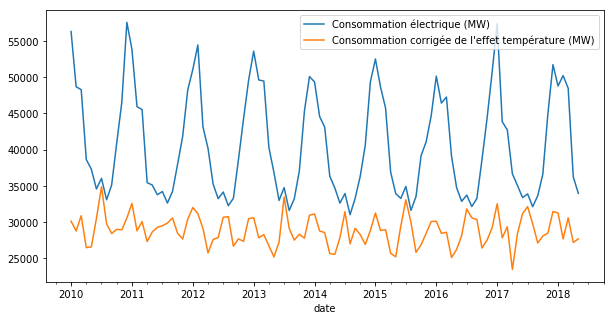

In [22]:
data.plot(y = ['consommation', 'consommation_corrigee'], 
          label=["Consommation électrique (MW)", "Consommation corrigée de l'effet température (MW)"],
          figsize=(10,5))

La consommation corrigée est plus stage, l'amplitude (en y) de la série est plus petite

Il semble que la consommation corrigée contienne également des cycles.

## Mission 2

<div class="panel panel-success">
    <div class="panel-heading"> 
        Ennoncé
    </div>
    <div class="panel-body"> 
        Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
    </div>
</div>


On va désaisonnaliser avec la méthode la plus utilisée : les moyennes mobiles. Etant donné que les saisons ont une période de 1 an, on va les cacluer sur 12 valeurs.

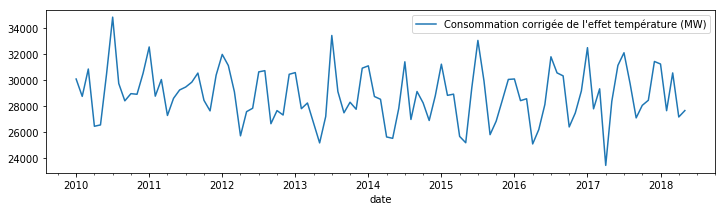

In [23]:
_ = data.plot(y='consommation_corrigee', label="Consommation corrigée de l'effet température (MW)", figsize=(12,3))

L'ampliture des périodes ne semble pas croître avec le temps, on choisis donc un modèle de décomposition **additif**.

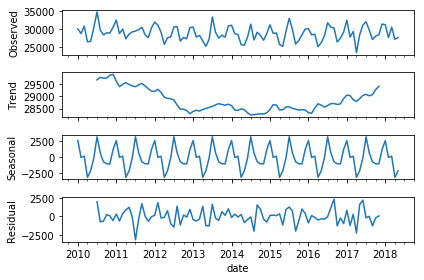

In [24]:
decompose_res = seasonal_decompose(data['consommation_corrigee'],  model='additive')
_ = decompose_res.plot()

ici, On a : 
- La tendance
- La saisonnalité, que l'algorithme a déterminé à 12 mois
- les résidus

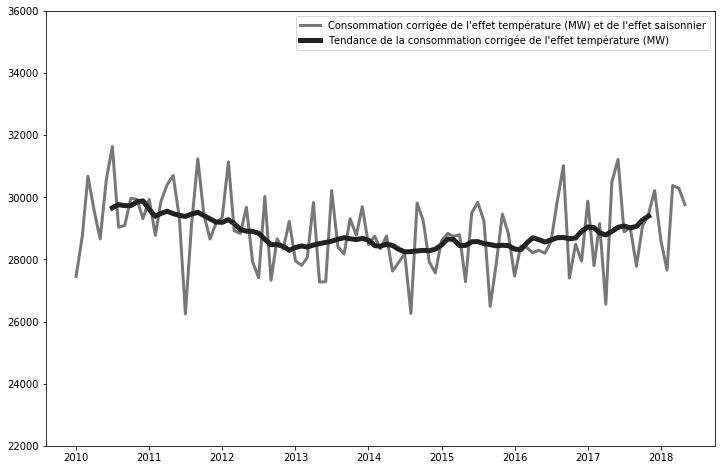

In [25]:
plt.figure(figsize=(12,8))


# consommation corrigée de l'effet température
# plt.plot(data['consommation_corrigee'], label="Consommation corrigée de l'effet température (MW)", 
#          color='#AAAAAA')

# consommation corrigée de l'effet température et des variations saisonières
plt.plot(data['consommation_corrigee'] - decompose_res.seasonal, 
         label="Consommation corrigée de l'effet température (MW) et de l'effet saisonnier",
         color='#777777', linewidth=3)

# tendance de la consommation corrigée de l'effet température
plt.plot(decompose_res.trend, label="Tendance de la consommation corrigée de l'effet température (MW)",
          color='#222222', linewidth=5)

plt.ylim((22000,36000))
plt.legend()

## Mission 3

<div class="panel panel-success">
    <div class="panel-heading"> 
        Ennoncé
    </div>
    <div class="panel-body"> 
        
Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.
    </div>
</div>


On va effectuer des prédictions sur un an. Comme nous avons des données jusqu'a mai 2018, nous allons prédire jusqu'a mai 2019

Nous allons comparer deux méthode : la méthode de Holt-Winters et la méthode SARIMA.

Pour pouvoir comparer les deux méthodes sur nos données et sélectionner la meilleure, nous allons également effectuer une analyse a posteriori.

### Préparation des données

In [26]:
DUREE_PREDITE = 12

In [27]:
troncature = DUREE_PREDITE

y = data['consommation_corrigee']

y_tronc = y[:-troncature]
y_a_prevoir = y[-troncature:]

### Prévision avec la méthode Holt Winters

On va utiliser le modèle additif, pour les mêmes raisons que précédemment et une période observée de 12.

In [28]:
# création du modèle
hw1_model = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='additive', seasonal='additive').fit()

# prédiction
hw1_pred = hw1_model.forecast(DUREE_PREDITE)
# on ajoute en index les dates correspondantes aux prédictions
hw1_pred = pd.Series(hw1_pred, index = pd.date_range(y.index.max(), periods=DUREE_PREDITE, freq='M'))

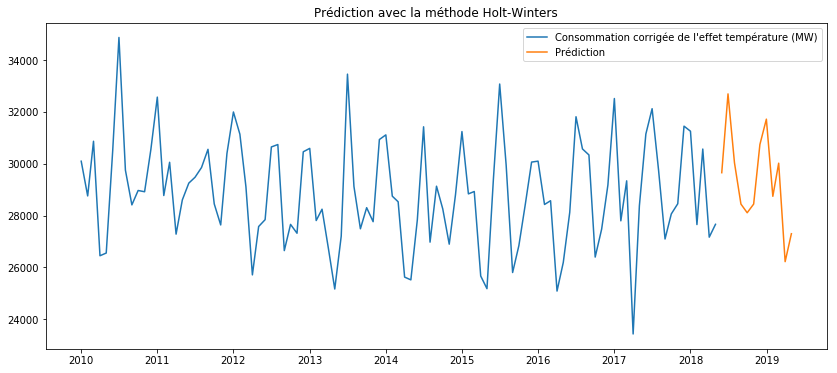

In [29]:
plt.figure(figsize=(14,6))
plt.plot(y, label="Consommation corrigée de l'effet température (MW)")
plt.plot(hw1_pred, label='Prédiction')
plt.title('Prédiction avec la méthode Holt-Winters')
_ =plt.legend()

#### Analyse a posteriori

Analyse a posteriori : Nous pouvons tester la performance du modèle en tentant de prédire la dernière année connue.
Nous pourrons alors comparer les valeurs prédite par le modèle avec les valeurs réels grâce aux indicateur RMSE et MAPE

In [30]:
# creation du modèle
hw2_model = ExponentialSmoothing(np.asarray(y_tronc), seasonal_periods=12, trend='additive', seasonal='additive').fit()

# prédiction
hw2_pred = hw2_model.forecast(DUREE_PREDITE)
# on ajoute en index les dates correspondantes aux prédictions
hw2_pred = pd.Series(hw2_pred, index = y_a_prevoir.index)

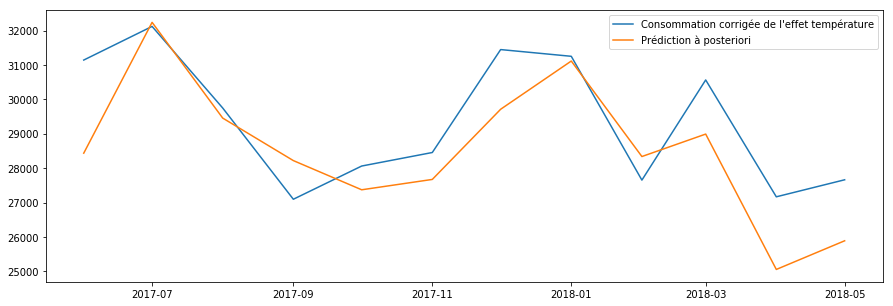

In [31]:
# afficher les n derniers mois
nb_mois = 12

plt.figure(figsize=(15,5))

plt.plot(y[-nb_mois:], label="Consommation corrigée de l'effet température")
plt.plot(hw2_pred.iloc[-nb_mois:], label='Prédiction à posteriori')


plt.legend()

La prévision semble assez précise

In [32]:
rmse(y_a_prevoir, hw2_pred)

1395.2179890354853

In [33]:
mape(y_a_prevoir, hw2_pred)

4.135080419829135

### Prévision avec la méthode SARIMA

La méthode SARIMA permet également d'effectuer une prédiction temporelle.

le modèle SARIMA permet de prédire un processus en le décomposant :
- avec un modèle AR, qui définie une relation linéaire entre un instant t et les **p** instant précédents
- avec un modèle MA , qui définie une relation entre une perturbation décorélée (un bruit blanc) a un instant t est les **q** instants précédents 
- il fait cette décomposition pour la partie saisonnière également, selon les paramètres P et Q.
- la stationnarisation de la série est intégrée au modèle, selon les paramètre d, D et la période s

Le modèle SARIMA s'écrit $SARIMA(p,d,q)(P,D,Q,S)_{s}$

Un processus est stationnaire si :
- l'esperance est constante a travers le temps
- la variance est constante a travers le temps
- les autocorélations entre deux moments séparés dans le temps sont constante

#### Observation des autcorrélogrammes simples

Observons le diagramme de corrélation simple sans appliquer de différenciations à y

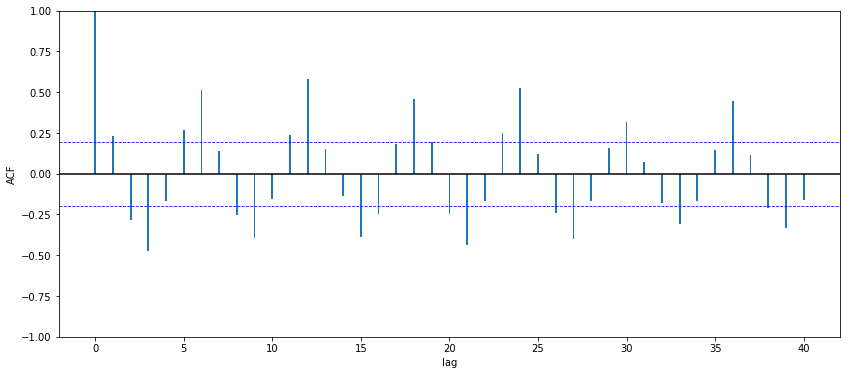

In [34]:
plot_sortie_acf(acf(np.asarray(y)), len(y))

In [35]:
y_dif1 = (y - y.shift(1)).dropna()

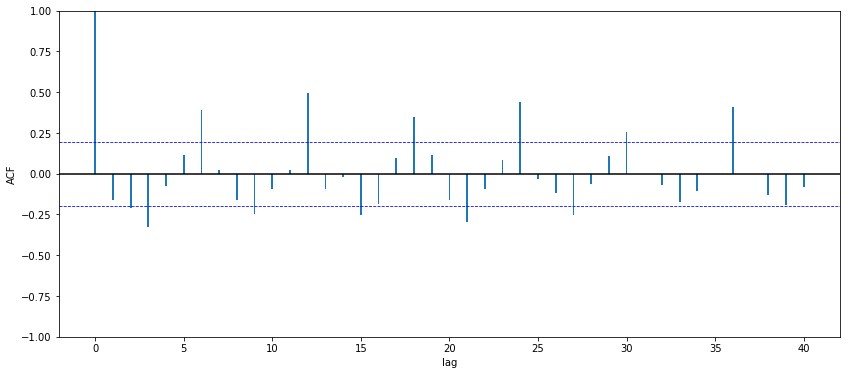

In [36]:
plot_sortie_acf(acf(np.asarray(y_dif1)), len(y_dif1))

On constate des pics tout les 6 mois, qui décroissent lentement. On effectue une différenciation de $(I -B^{12})$

In [37]:
y_dif2 = (y_dif1 - y_dif1.shift(12)).dropna()

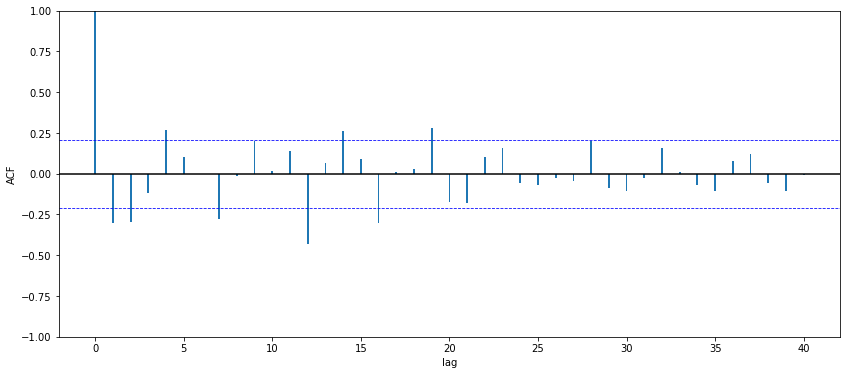

In [38]:
plot_sortie_acf(acf(np.asarray(y_dif2)), len(y_dif2))

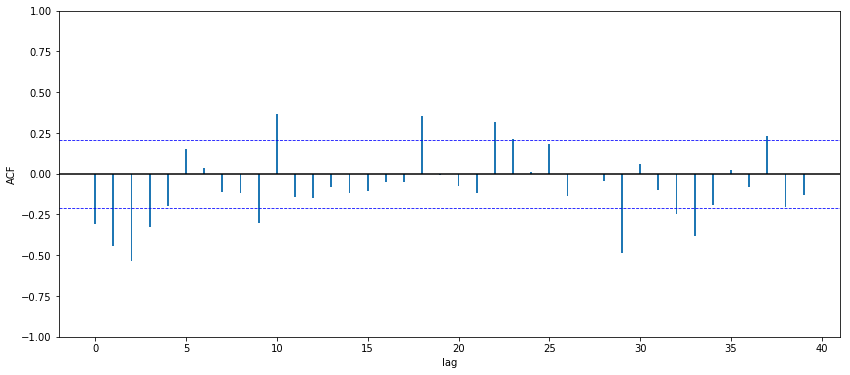

In [39]:
plot_sortie_acf(pacf(np.asarray(y_dif2)), len(y_dif2), pacf=True)

On ne constate plus de pics significatifs (au dessus du pointillet, qui est le seuil a 5%) à intervalle régulier. 

Une différenciation de $(I -B^{12})$ semble suffir pour stationnarier la série temporelle.

#### Modèle SARIMA

Pour trouver le meilleur modèle, nous allons faire une analyse a posteriori pour toute les configurations possibles de paramètres. Nous sélectionnerons celle avec la plus basse valeur pour le MAPE

In [40]:
# toute les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))
# toute les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]

# nombre de configurations
n = len(pdq_list) * len(PDQ_list)


grid_search_result = pd.DataFrame({'modele':[], 'AIC':[], 'BIC':[]})
counter = 1
s_time = time()

for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            # calcul du modèle sur y_tronc
            mod = SARIMAX(np.asarray(y_tronc),
                          order = pdq,
                          seasonal_order = PDQ,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            result = mod.fit()
            
            # on fait une prédiction sur 1 ans
            prediction = result.get_forecast(DUREE_PREDITE).predicted_mean
           
            # on stocke l'AIC, le BIC le RMCE et le MAPE de ce modèle
            grid_search_result = grid_search_result.append({'modele':f"{pdq}x{PDQ}", 
                            'aic':result.aic, 
                            'bic':result.bic,
                            'rmse': rmse(y_a_prevoir, prediction),
                            'mape': mape(y_a_prevoir, prediction)}, 
                            ignore_index=True)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

324/324 - 221s


In [41]:
grid_search_result[['modele', 'mape']].sort_values('mape')

,modele,mape
139,"(1, 0, 1)x(2, 0, 1, 12)",3.413167e+00
318,"(2, 1, 2)x(2, 0, 0, 12)",3.418456e+00
319,"(2, 1, 2)x(2, 0, 1, 12)",3.448125e+00
285,"(2, 1, 0)x(2, 1, 0, 12)",3.485421e+00
169,"(1, 1, 0)x(1, 0, 1, 12)",3.529038e+00
210,"(1, 1, 2)x(2, 0, 0, 12)",3.553575e+00
283,"(2, 1, 0)x(2, 0, 1, 12)",3.575302e+00
280,"(2, 1, 0)x(1, 1, 1, 12)",3.604991e+00
213,"(1, 1, 2)x(2, 1, 0, 12)",3.673627e+00
286,"(2, 1, 0)x(2, 1, 1, 12)",3.682786e+00


Les solutions : 
(1,0,1)(2,0,1), (2,1,2)(2,0,0)	, (2,1,2)(2,0,1)
ne donne pas de coefficients significatifs.

On retient la solution (2,1,0)(2,1,0)

In [42]:
sarima_model = SARIMAX(np.asarray(y), 
                       order=(2,1,0), 
                       seasonal_order=(2,1,0,12), 
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_res = sarima_model.fit()
#sarima_res.summary()

In [43]:
def ljungbox(sarima_res, retards=[6, 12, 18, 24, 30, 36]):
    return pd.Series(
            {lags: acorr_ljungbox(sarima_res.resid, lags=lags)[1].mean() 
                  for lags in retards
            }
        )

def display_residuals(sarima_result, seuil=0.05):
    
    # shapiro-wilk
    shapiro_pval = stats.shapiro(sarima_result.resid)[1]
    print(f"\nNormalité des résidus - p-valeur SW = {shapiro_pval:.3f} {'X' if shapiro_pval < seuil else 'OK'}", )
    
    # on affiche le Q-Q plot
    fig, ax = plt.subplots(figsize=(2,2))
    _ = st.probplot(sarima_result.resid, plot=ax, fit=True)
    plt.title('Q-Q plot des résidus')
    
    # calcul des retards
    print("\npvaleurs des tests de ljungbox pour les retards:")
    for (retard, pval) in ljungbox(sarima_result).iteritems():
        print(f"{retard}:{pval:.3f}  {'X' if pval < seuil else 'OK'}", end=' | ')


Normalité des résidus - p-valeur SW = 0.000 X

pvaleurs des tests de ljungbox pour les retards:
6:0.050  X | 12:0.095  OK | 18:0.169  OK | 24:0.283  OK | 30:0.360  OK | 36:0.437  OK | 

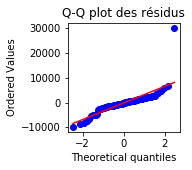

In [45]:
display_residuals(sarima_res)

#### Analyse a posteriori

In [46]:
# creation du modele
sarima2_model = SARIMAX(np.asarray(y_tronc), 
                        order=(2,1,0), 
                        seasonal_order=(2,1,0,12), 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)

sarima2_res = sarima2_model.fit()
# prediction
sarima2_pred = sarima2_res.get_forecast(DUREE_PREDITE)

# on créé un dataframe qui contient pour chacune des dates prédites, la valeurs et l'intervalle de confiance
sarima2_pred = pd.DataFrame(
               {'prediction': sarima2_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima2_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima2_pred.conf_int(alpha=0.05)]
               }, 
               index= y_a_prevoir.index)

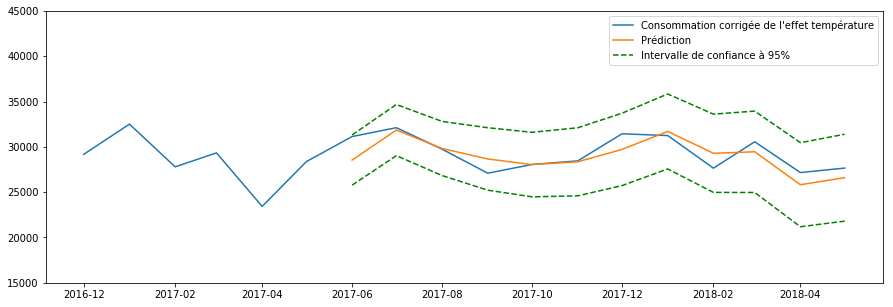

In [47]:
# afficher les n derniers mois
nb_mois = 18

plt.figure(figsize=(15,5))
plt.ylim((15000,45000))

plt.plot(y[-nb_mois:], label="Consommation corrigée de l'effet température")

plt.plot(sarima2_pred.iloc[-nb_mois:]['prediction'], label='Prédiction')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_sup'], label='Intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_inf'], label='', color='g', linestyle='--')

plt.legend()

In [48]:
rmse(y_a_prevoir, sarima2_pred['prediction'])

1268.8021833729044

In [49]:
mape(y_a_prevoir, sarima2_pred['prediction'])

3.485421028309833

#### Prédiction

In [50]:
# prédiction
sarima_pred = sarima_res.get_forecast(DUREE_PREDITE)

# on créé un dataframe qui contient pour chacune des dates prédites, la valeurs et l'intervalle de confiance
prediction = pd.DataFrame(
               {'prediction': sarima_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred.conf_int(alpha=0.05)]
               }, 
               index= pd.date_range(y.index.max(), periods=DUREE_PREDITE, freq='M'))

##### Graphique

In [51]:
# on ajoute la dernière valeur connue aux valeurs prédites, pour avoir un trait continue (optionnel)
prediction.loc[y.index.max(), 'prediction'] = y[y.index.max()]
prediction.sort_index(inplace=True)

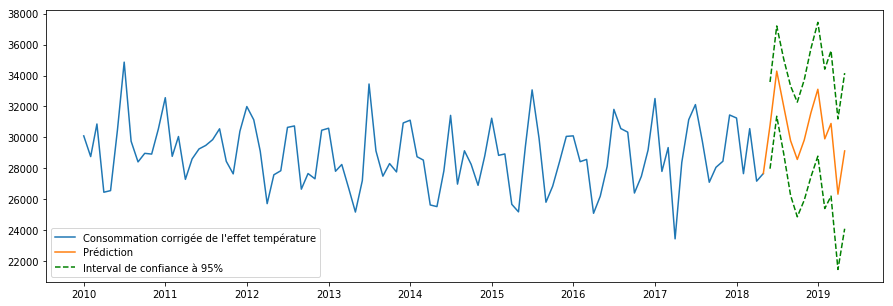

In [52]:
plt.figure(figsize=(15,5))
plt.plot(y, label="Consommation corrigée de l'effet température")
plt.plot(prediction['prediction'], label='Prédiction')
plt.plot(prediction['conf_sup'], label='Interval de confiance à 95%', color='g', linestyle='--')
plt.plot(prediction['conf_inf'], label='', color='g', linestyle='--')
plt.legend()

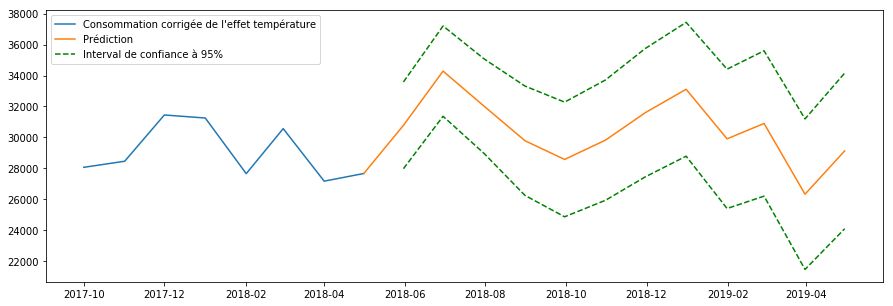

In [53]:
# on peut restreindre l'affichage a des dates précises
sd = datetime(2017,10,1) # None
ed = None

plt.figure(figsize=(15,5))
plt.plot(y[sd:ed], label="Consommation corrigée de l'effet température")
plt.plot(prediction.loc[sd:ed,'prediction'], label='Prédiction')
plt.plot(prediction.loc[sd:ed,'conf_sup'], label='Interval de confiance à 95%', color='g', linestyle='--')
plt.plot(prediction.loc[sd:ed,'conf_inf'], label='', color='g', linestyle='--')
plt.legend()

### Mission 2 : Conclusion

SARIMA offre de meilleurs indicateur que HW, nous privilégions SARIMA pour notre prédiction business